In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore',category=UserWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria
from turbustat.statistics import PowerSpectrum
from astropy.io import fits
from tqdm.auto import tqdm
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

In [2]:
def adjust_spines(ax, spines,lw=None,movepos=None):
    ax.xaxis.set_tick_params(width=lw)
    ax.yaxis.set_tick_params(width=lw)
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', movepos))  # outward by 10 points
            spine.set_linewidth(lw)
        else:
            spine.set_color('none')  # don't draw spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [3]:
def build_a_xarray_dataset(ds=None,varname=None,varfile=None):
    def build_xa(arraydata=None,arrayname=None):
        da = xr.DataArray(data=arraydata,dims=['samples','azimuth','radius','weight'],coords={'samples':np.linspace(0,350,351),'azimuth':np.linspace(0,359,360),\
                                                                                    'radius':np.linspace(0,166,167)*3,'weight':[0,1,2,3,4]},name=arrayname)
        return da
    # Complete the code
    for varobj,varnamen in zip(varfile,varname):
        da = build_xa(varobj.reshape(351,360,167,5),varnamen)
        ds = xr.merge( [ds , da ] )
    return ds

#### Read

In [4]:
############################################################################################################################################################
# Settings
############################################################################################################################################################
folderpath='../output/spectral/vert_decomp/'
varname = [obj.split('/')[-1][:-7] for obj in sorted(glob.glob(folderpath+'*weights'))]
ds = xr.Dataset(coords=dict(sample=np.linspace(0,350,351),azimuth=np.linspace(0,359,360),radius=np.linspace(0,166,167)*3,
                           weight=[0,1,2,3,4]))

############################################################################################################################################################
# Read
############################################################################################################################################################
varfile = [read_and_proc.depickle(obj) for obj in sorted(glob.glob(folderpath+'*weights'))]   
full_ds = build_a_xarray_dataset(ds=ds,varname=varname,varfile=varfile)

In [5]:
varname

['IR', 'NOIR', 'NORAD', 'Q', 'RAD', 'THETA', 'U', 'V', 'W']

#### Polar to Cartesian

In [4]:
import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""
    
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))
    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0]*2,PWnew.shape[0]*2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))

In [7]:
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,166,167)*3),np.linspace(0,166,167)*3))

In [8]:
from tqdm.auto import tqdm
def weights_to_cart(data=None):
    output = []
    for i in tqdm(range(5)):
        temp = data[:,:,:,i]
        output.append([np.fliplr(np.flipud((proc_tocart(temp[tobj,:,:],ANGLE,True,False)))) for tobj in (range(len(temp[:,0,0])))])
    return np.swapaxes(np.swapaxes(np.asarray(output),0,-1),0,1)

In [9]:
Uproc,Vproc,Wproc,THETAproc = weights_to_cart(data=full_ds['U'].data),weights_to_cart(data=full_ds['V'].data),weights_to_cart(data=full_ds['W'].data),weights_to_cart(data=full_ds['THETA'].data)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
procWEIGHTS = xr.Dataset(data_vars=dict(U=(['samples','X','Y','weight'],Uproc),\
                                        V=(['samples','X','Y','weight'],Vproc),\
                                        W=(['samples','X','Y','weight'],Wproc),\
                                       THETA=(['samples','X','Y','weight'],THETAproc)),
                         coords=dict(samples=np.linspace(0,350,351),X=NEWCART_axis,Y=NEWCART_axis,weight=[0,1,2,3,4]),
                         attrs=dict(description='Data for Fourier Analysis'))

In [11]:
read_and_proc.save_to_pickle('./UVWTHETA_weights',procWEIGHTS,'PICKLE')

#### Read2

In [4]:
procQWEIGHTS = read_and_proc.depickle('./QRADNORAD_weights')
procUVWTHWEIGHTS = read_and_proc.depickle('./UVWTHETA_weights')

In [242]:
class pspec:
    def __init__(self,img=None):
        self.img=np.swapaxes(img,0,1)
    
    def do_fft(self):
        ndim = len(self.img.shape)
        if ndim < 2 or ndim > 3:
            raise TypeError("Dimension of image must be 2D or 3D.")
        last_dim = self.img.shape[-1]
        fft_abs = np.abs(np.fft.rfftn(self.img))
        if ndim == 2:
            if last_dim % 2 == 0:
                fftstar_abs = fft_abs.copy()[:, -2:0:-1]
            else:
                fftstar_abs = fft_abs.copy()[:, -1:0:-1]
            fftstar_abs[1::, :] = fftstar_abs[:0:-1, :]
            return np.concatenate((fft_abs, fftstar_abs), axis=1)
        
    def do_my_fft(self):
        ft2 = np.fft.ifftshift(self.img)
        ft2 = np.fft.fft2(self.img)
        ft2s = np.fft.fftshift(ft2)
        return ft2,ft2s
    
    def compute_pspec(self):
        fft = np.fft.fftshift(self.do_fft())
        self._ps2D = np.power(fft, 2.)
        
    def compute_radial_pspec(self):
        self.compute_pspec()
        ps2d = self._ps2D[::-1]
        return ps2d

In [261]:
from astropy import units as u
#a = np.swapaxes(procQWEIGHTS['NORAD'][36,:,:,1].data,0,1)
#pspecb = PowerSpectrum([(a-np.mean(a))/np.std(a),fits.Header('TEST')])
#pspecb = PowerSpectrum([a,fits.Header('TEST')])
#pspecb.run(verbose=False)

#a = np.swapaxes(procQWEIGHTS['RAD'][36,:,:,1].data,0,1)
#pspec = PowerSpectrum([(a-np.mean(a))/np.std(a),fits.Header('TEST')])
#pspec = PowerSpectrum([a,fits.Header('TEST')])
#pspec.run(verbose=False)
a = np.swapaxes(procQWEIGHTS['NORAD'][40,:,:,1].data,0,1)
a3 = np.swapaxes(procQWEIGHTS['Q'][40,:,:,1].data,0,1)
testspec = pspec(a).do_my_fft()[1]
a2 = np.swapaxes(procQWEIGHTS['RAD'][40,:,:,1].data,0,1)
testspec2 = pspec(a2).do_my_fft()[1]

In [158]:
from scipy.ndimage import uniform_filter1d

In [220]:
def complexe_modulo(z):
    a = z.real
    b = z.imag
    return np.sqrt(a**2+b**2)

In [230]:
np.var(a),np.sum(a**2)

(1.4700610312771628e-08, 0.0017731579501168886)

In [244]:
(np.sum(np.sum(np.abs(testspec[:,:])**2,axis=0)))/np.sum(a**2)

111555.99999999994

In [246]:
(np.sum(np.sum(np.abs(testspec[:,:])**2,axis=0)))/np.sum(a**2)

111555.99999999996

In [203]:
np.sqrt(((np.sum(np.sum(testspec[:,:]**2,ky_array[:,0]),kx_array[0,:]))/np.var(a)).real**2+\
((np.sum(np.sum(testspec[:,:]**2,ky_array[:,0]),kx_array[0,:]))/np.var(a)).imag**2)

TypeError: only integer scalar arrays can be converted to a scalar index

In [199]:
np.sqrt(((np.trapz(np.trapz(testspec[:,:]**2,ky_array[:,0],axis=0),kx_array[0,:]))/np.var(a)).real**2+\
((np.trapz(np.trapz(testspec[:,:]**2,ky_array[:,0],axis=0),kx_array[0,:]))/np.var(a)).imag**2)

1436979263.4311373

In [192]:
np.sqrt(((np.trapz(np.trapz(testspec[167:,167:]**2,ky_array[:167,0],axis=0),kx_array[0,:167]))/np.var(a3)).real**2+\
((np.trapz(np.trapz(testspec[167:,167:]**2,ky_array[:167,0],axis=0),kx_array[0,:167]))/np.var(a3)).imag**2)

21965.934938526058

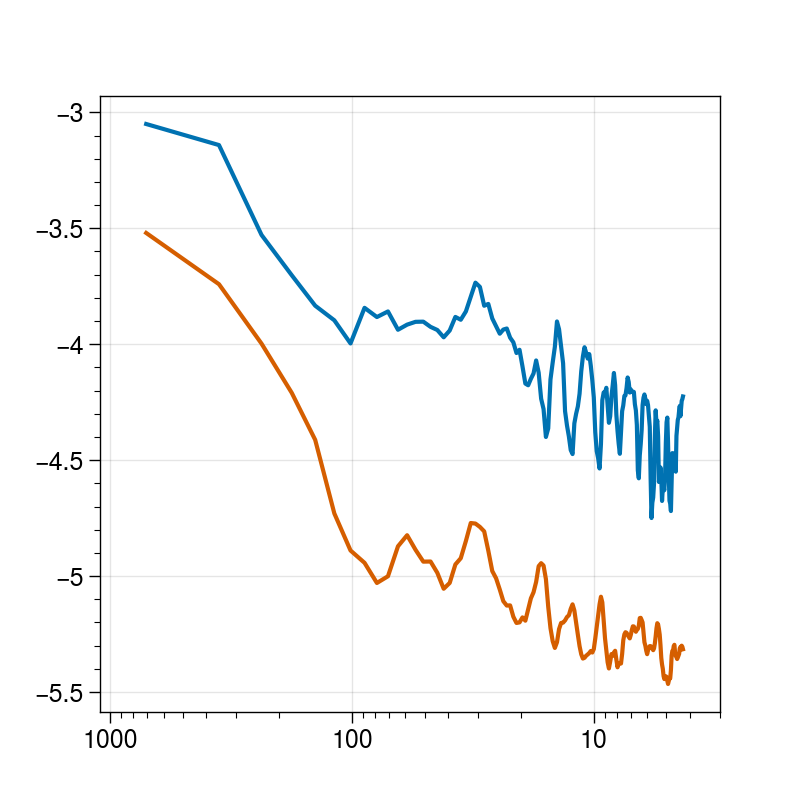

In [266]:
a = uniform_filter1d(np.log10(np.trapz(testspec[167:,167:],kx_array[0,:167],axis=1)).real,5)
plt.plot(2*np.pi/WV[0,:][0:167],a)
b = uniform_filter1d(np.log10(np.trapz(testspec2[167:,167:],kx_array[0,:167],axis=1)).real,5)
plt.plot(2*np.pi/WV[0,:][0:167],b)
#plt.pcolormesh(np.abs(testspec))
plt.xscale('log')
plt.xlim(1100,3)
plt.show()

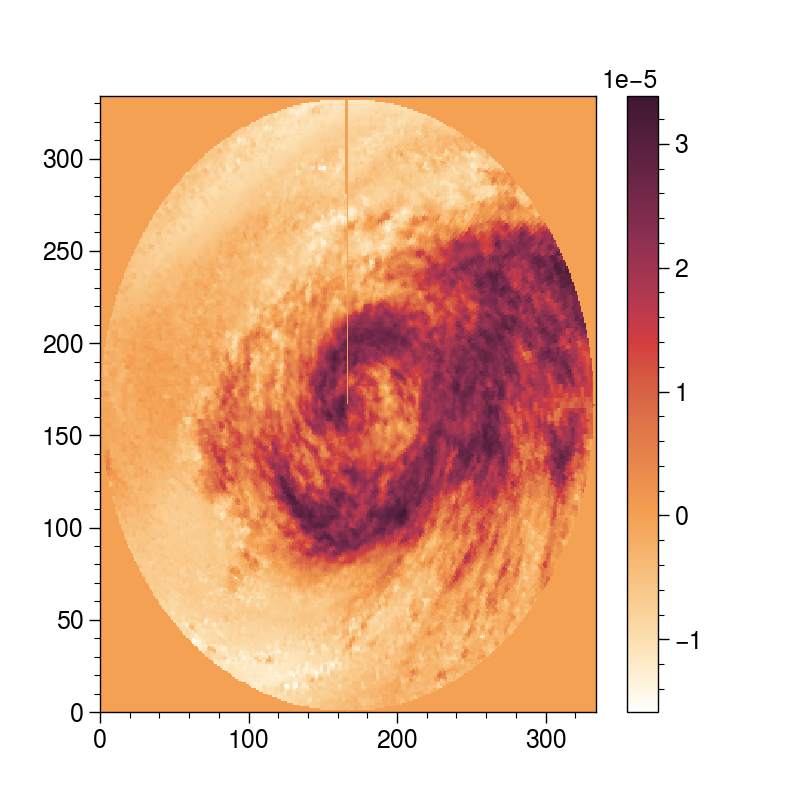

In [28]:
#plt.pcolormesh(np.swapaxes(procQWEIGHTS['NORAD'][60,:,:,3],0,1))
plt.pcolormesh(np.swapaxes(procQWEIGHTS['RAD'][60,:,:,3],0,1))
plt.colorbar()
plt.show()

In [40]:
2*np.pi/WV[0,:][0:167]

array([         inf, 708.52099475, 354.26049737, 236.17366492,
       177.13024869, 141.70419895, 118.08683246, 101.21728496,
        88.56512434,  78.72455497,  70.85209947,  64.41099952,
        59.04341623,  54.50161498,  50.60864248,  47.23473298,
        44.28256217,  41.67770557,  39.36227749,  37.29057867,
        35.42604974,  33.73909499,  32.20549976,  30.80526064,
        29.52170811,  28.34083979,  27.25080749,  26.24151832,
        25.30432124,  24.43175844,  23.61736649,  22.85551596,
        22.14128109,  21.47033317,  20.83885279,  20.24345699,
        19.68113874,  19.14921607,  18.64528934,  18.16720499,
        17.71302487,  17.28099987,  16.86954749,  16.47723244,
        16.10274988,  15.74491099,  15.40263032,  15.07491478,
        14.76085406,  14.45961214,  14.17041989,  13.89256852,
        13.62540375,  13.36832066,  13.12075916,  12.8821999 ,
        12.65216062,  12.43019289,  12.21587922,  12.00883042,
        11.80868325,  11.61509827,  11.42775798,  11.24

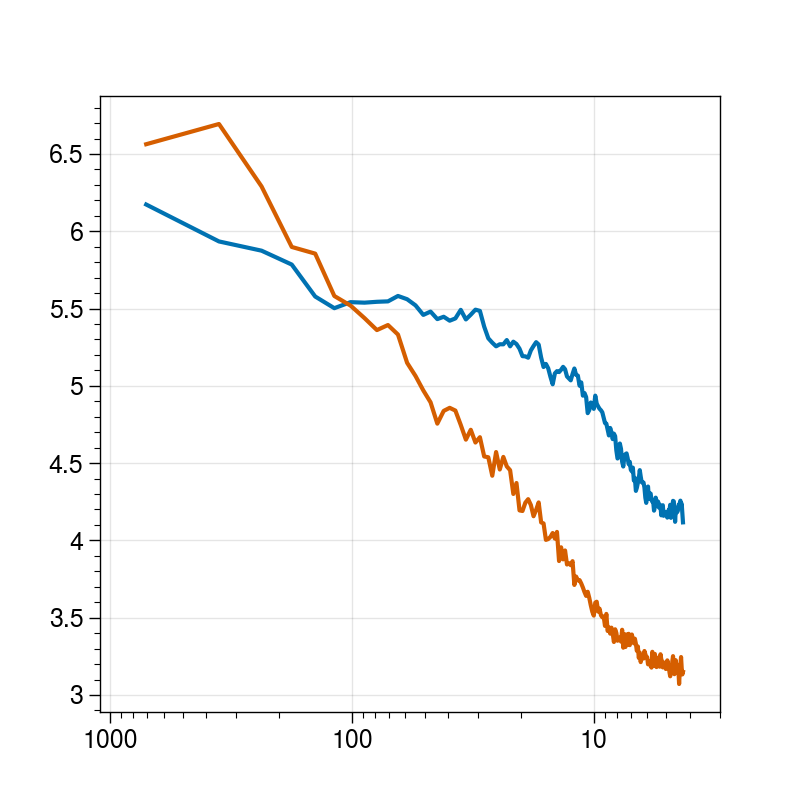

In [80]:
plt.plot(2*np.pi/WV[0,:][0:167],np.log10(np.trapz(pspecb.ps2D[167:,167:],kx_array[0,:167],axis=1)[:]))
plt.plot(2*np.pi/WV[0,:][0:167],np.log10(np.trapz(pspec.ps2D[167:,167:],kx_array[0,:167],axis=1)[:]))
plt.xscale('log')
plt.xlim(1100,3)
plt.show()

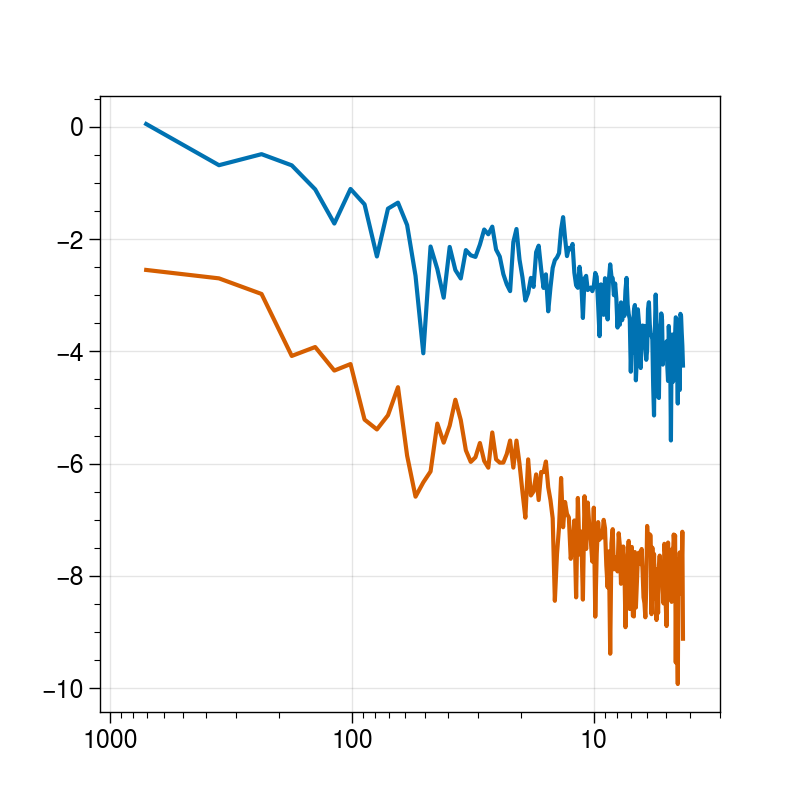

In [82]:
#plt.plot(2*np.pi/WV[0,:][0:167],np.log10((pspecb.ps1D))[0:167])
#plt.plot(2*np.pi/WV[0,:][0:167],np.log10((pspec.ps1D))[0:167])
#plt.plot(2*np.pi/WV[0,:][0:167],np.log10((pspecb.ps1D))[0:167])
#plt.plot(2*np.pi/WV[0,:][0:167],np.log10((pspec.ps1D))[0:167])
plt.plot(2*np.pi/WV[0,:][0:167],np.log10(pspecb.ps2D[int(334/2):,int(334/2)]))
plt.plot(2*np.pi/WV[0,:][0:167],np.log10(pspec.ps2D[int(334/2):,int(334/2)]))
plt.xscale('log')
plt.xlim(1100,3)
plt.show()

In [265]:
from astropy import units as u
from tqdm.auto import tqdm

storerad = []
for i in tqdm(range(36,40)):#procWEIGHTS['RAD'][:,:,:,1].shape[0])):
    pspeca = PowerSpectrum([(procWEIGHTS['RAD'][i,:,:,1].data-np.mean(procWEIGHTS['RAD'][i,:,:,1].data))/np.std(procWEIGHTS['RAD'][i,:,:,1].data),fits.Header('TEST')])  
    pspeca.run(verbose=False)
    storerad.append(pspeca)

storenorad = []
for i in tqdm(range(36,40)):#procWEIGHTS['NORAD'][:,:,:,1].shape[0])):
    pspeca = PowerSpectrum([(procWEIGHTS['NORAD'][i,:,:,1].data-np.mean(procWEIGHTS['NORAD'][i,:,:,1].data))/np.std(procWEIGHTS['NORAD'][i,:,:,1].data),fits.Header('TEST')])  
    pspeca.run(verbose=False)
    storenorad.append(pspeca)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [291]:
np.fft.fft2(ft2).shape

(334, 334)

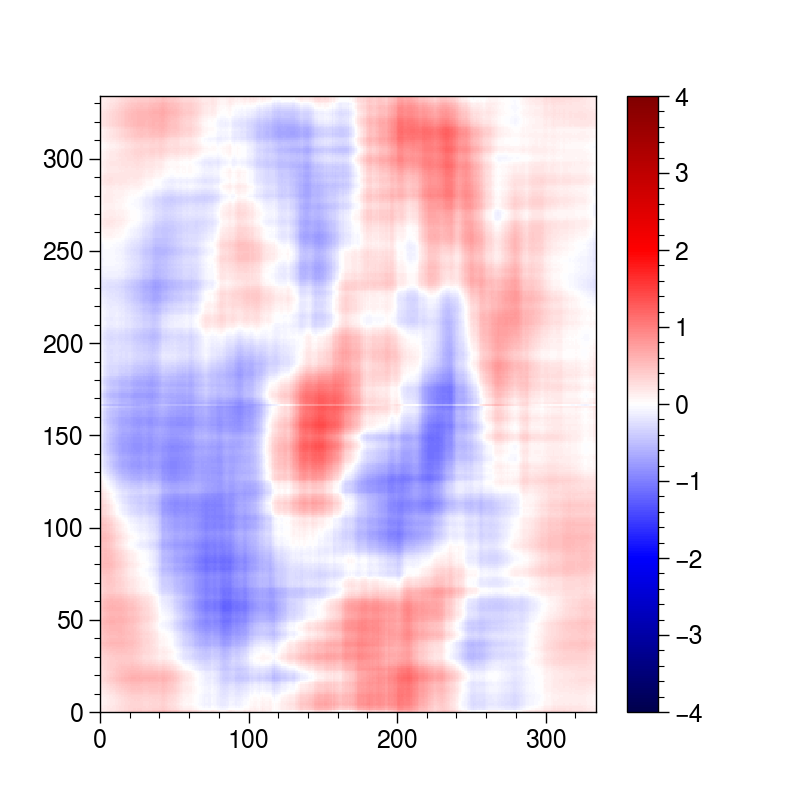

In [317]:
testA = (np.fft.rfftn((procWEIGHTS['RAD'][36,:,:,1]-np.mean(procWEIGHTS['RAD'][36,:,:,1]))/np.std(procWEIGHTS['RAD'][36,:,:,1])))
testA = (np.fft.fftshift(testA))
testB = pspec((procWEIGHTS['RAD'][36,:,:,1]-np.mean(procWEIGHTS['RAD'][36,:,:,1]))/np.std(procWEIGHTS['RAD'][36,:,:,1])).compute_radial_pspec()
#plt.pcolormesh(np.fft.irfftn(np.fft.ifftshift(storerad[0].ps2D)))#np.fft.irfftn(testA))
ft2 = np.fft.ifftshift((procWEIGHTS['RAD'][36,:,:,1]-np.mean(procWEIGHTS['RAD'][36,:,:,1]))/np.std(procWEIGHTS['RAD'][36,:,:,1]))
ft2 = np.fft.fft2(ft2)
im_fft2 = ft2.copy()*0
#im_fft2[0:-1] = 0
#im_fft2[:,0:-1] = 0
im_fft2[1] = ft2.copy()[1]
im_fft2[-2] = ft2.copy()[-2]
im_fft2[:,1] = ft2.copy()[:,1]
im_fft2[:,-2] = ft2.copy()[:,-2]
ft2 = np.fft.fftshift(im_fft2)
plt.pcolormesh(np.real(np.fft.fftshift((np.fft.ifft2(np.fft.ifftshift(ft2))))),vmin=-4,vmax=4,cmap='seismic')
plt.colorbar()
plt.show()

In [318]:
ft2 = np.fft.ifftshift((procWEIGHTS['RAD'][36,:,:,1]-np.mean(procWEIGHTS['RAD'][36,:,:,1]))/np.std(procWEIGHTS['RAD'][36,:,:,1]))
ft2 = np.fft.fft2(ft2)
im_fft2 = ft2.copy()*0
#im_fft2[0:-1] = 0
#im_fft2[:,0:-1] = 0
#im_fft2[1] = ft2.copy()[1]
#im_fft2[-2] = ft2.copy()[-2]
#im_fft2[:,1] = ft2.copy()[:,1]
#im_fft2[:,-2] = ft2.copy()[:,-2]
ft2 = np.fft.fftshift(ft2)

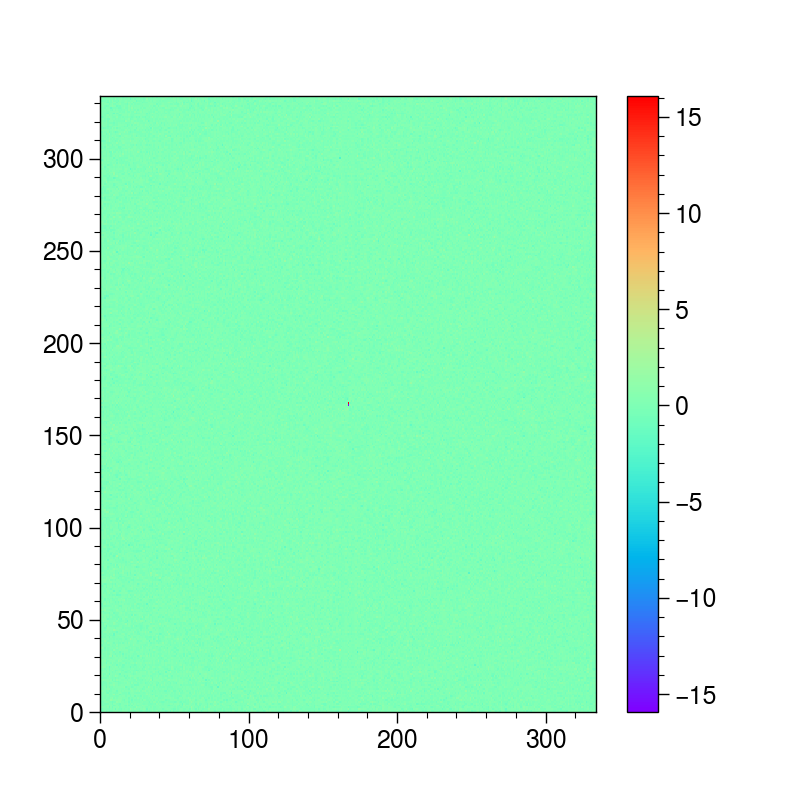

In [321]:
plt.pcolormesh(np.log10(np.sqrt(storerad[0].ps2D))-np.log10(np.abs(ft2)),cmap='rainbow')
plt.colorbar()
plt.show()

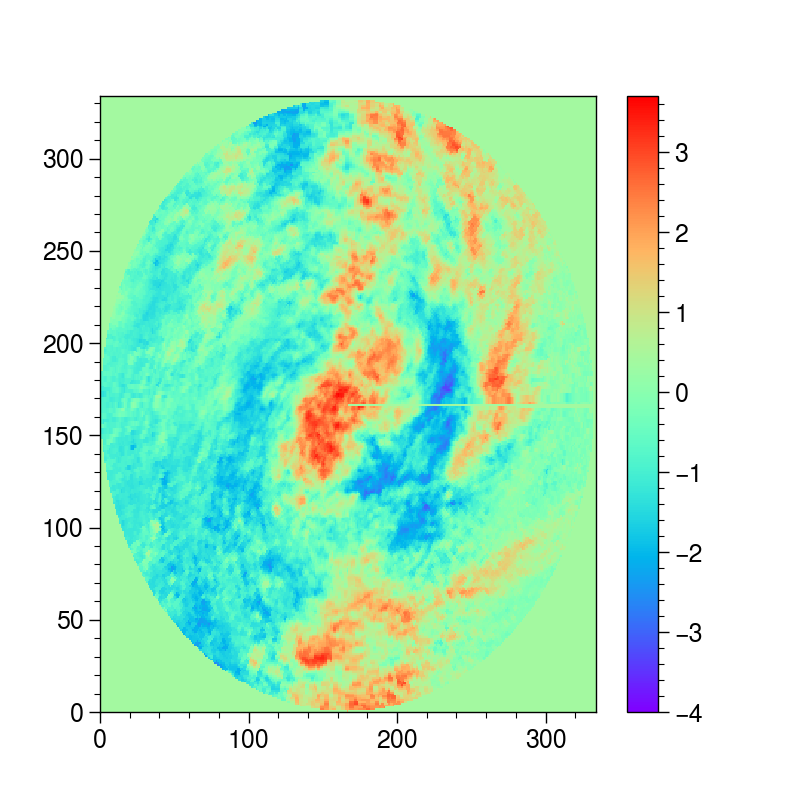

In [322]:
plt.pcolormesh((procWEIGHTS['RAD'][36,:,:,1]-np.mean(procWEIGHTS['RAD'][36,:,:,1]))/np.std(procWEIGHTS['RAD'][36,:,:,1]),vmin=-4,cmap='rainbow')
plt.colorbar()
plt.show()

In [224]:
from astropy import units as u
from tqdm.auto import tqdm

storerad1 = []
for i in tqdm(range(procWEIGHTS['RAD'][:,:,:,1].shape[0])):
    pspeca = PowerSpectrum([(procWEIGHTS['RAD'][i,:,:,1].data-np.mean(procWEIGHTS['RAD'][i,:,:,1].data))/np.std(procWEIGHTS['RAD'][i,:,:,1].data),fits.Header('TEST')])  
    pspeca.run(verbose=False)
    storerad1.append(pspeca.ps1D)

storenorad1 = []
for i in tqdm(range(procWEIGHTS['NORAD'][:,:,:,1].shape[0])):
    pspeca = PowerSpectrum([(procWEIGHTS['NORAD'][i,:,:,1].data-np.mean(procWEIGHTS['NORAD'][i,:,:,1].data))/np.std(procWEIGHTS['NORAD'][i,:,:,1].data),fits.Header('TEST')])  
    pspeca.run(verbose=False)
    storenorad1.append(pspeca.ps1D)

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

In [227]:
storerad3 = []
for i in tqdm(range(procWEIGHTS['RAD'][:,:,:,1].shape[0])):
    pspeca = PowerSpectrum([(procWEIGHTS['RAD'][i,:,:,3].data-np.mean(procWEIGHTS['RAD'][i,:,:,3].data))/np.std(procWEIGHTS['RAD'][i,:,:,3].data),fits.Header('TEST')])  
    pspeca.run(verbose=False)
    storerad3.append(pspeca.ps1D)
    
storenorad3 = []
for i in tqdm(range(procWEIGHTS['NORAD'][:,:,:,1].shape[0])):
    pspeca = PowerSpectrum([(procWEIGHTS['NORAD'][i,:,:,3].data-np.mean(procWEIGHTS['NORAD'][i,:,:,3].data))/np.std(procWEIGHTS['NORAD'][i,:,:,3].data),fits.Header('TEST')])  
    pspeca.run(verbose=False)
    storenorad3.append(pspeca.ps1D)

  0%|          | 0/351 [00:00<?, ?it/s]

  0%|          | 0/351 [00:00<?, ?it/s]

In [228]:
read_and_proc.save_to_pickle('../output/storeRAD_3',storerad3,'PICKLE')
read_and_proc.save_to_pickle('../output/storeNORAD_3',storenorad3,'PICKLE')
#read_and_proc.save_to_pickle('../output/storeRAD_1',storerad1,'PICKLE')
#read_and_proc.save_to_pickle('../output/storeNORAD_1',storenorad1,'PICKLE')
#read_and_proc.save_to_pickle('../output/storeRAD_2',storerad2,'PICKLE')
#read_and_proc.save_to_pickle('../output/storeNORAD_2',storenorad2,'PICKLE')

In [38]:
WV = np.sqrt(kx_array**2+kx_array**2)

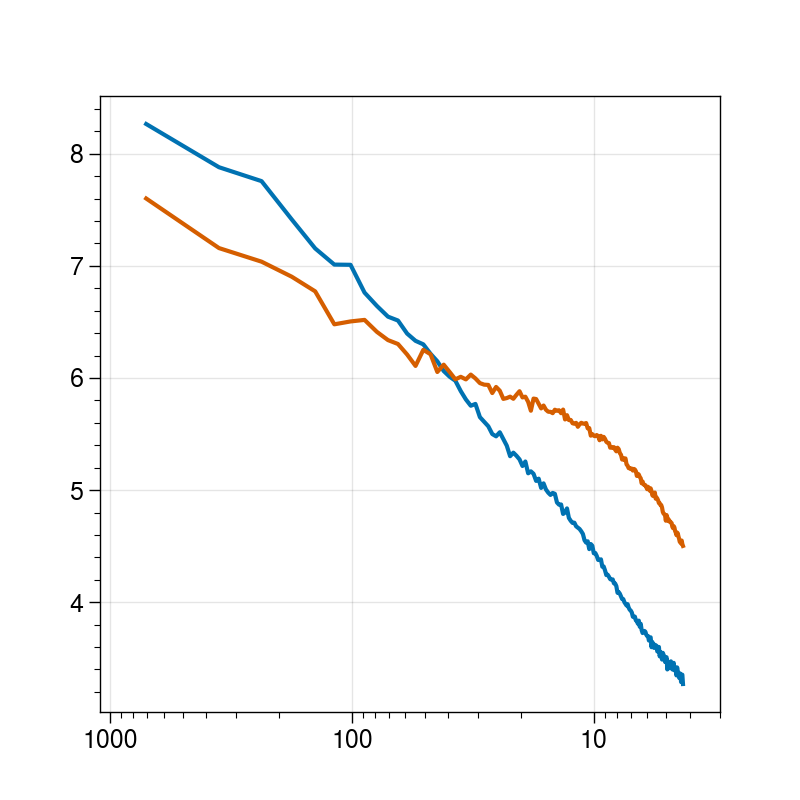

In [208]:

plt.plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(storerad1),axis=0))[0:167])
plt.plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(storenorad1),axis=0))[0:167])
plt.xscale('log')
#plt.loglog((2*np.pi/kx_array[0,:][0:167]),np.log10(pspecc.ps1D)[0:167])
plt.xlim(1100,3)
plt.show()
#plt.xlim(5,0)

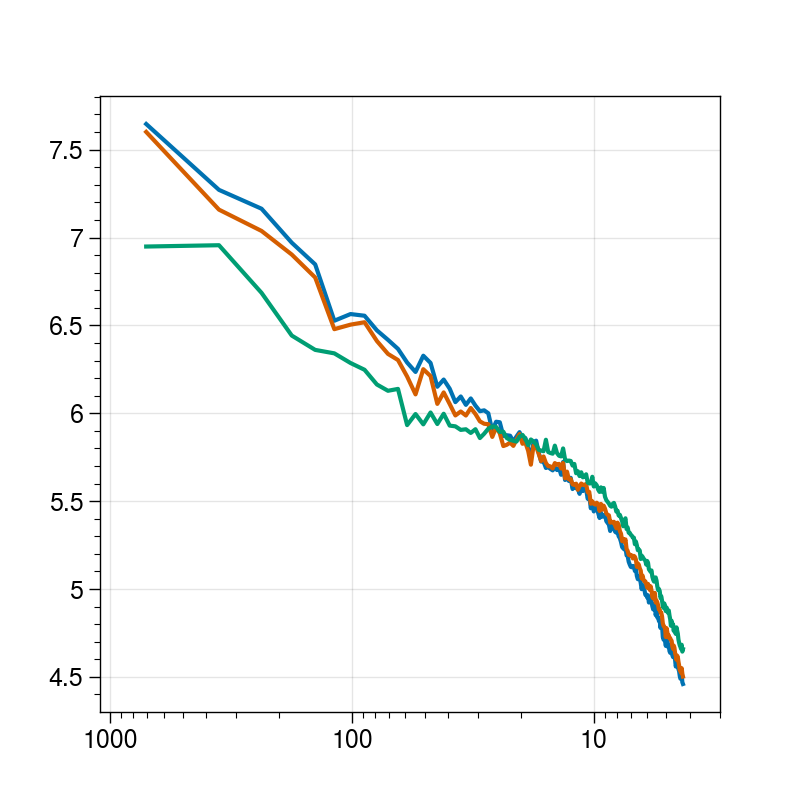

In [222]:
plt.plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(storenorad),axis=0))[0:167])
plt.plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(storenorad1),axis=0))[0:167])
plt.plot((2*np.pi/WV[0,:][0:167]),np.log10(np.mean(np.asarray(storenorad2),axis=0))[0:167])
plt.xscale('log')
#plt.loglog((2*np.pi/kx_array[0,:][0:167]),np.log10(pspecc.ps1D)[0:167])
plt.xlim(1100,3)
plt.show()
#plt.xlim(5,0)

In [37]:
# assign some real spatial co-ordinates to the grid points   
# first define the edge values
x_min = -167.0*3
x_max = 167.0*3
y_min = -167.0*3
y_max = 167.0*3

# then create some empty 2d arrays to hold the individual cell values
x_array = np.zeros( (334,334) , dtype = float )
y_array = np.zeros( (334,334) , dtype = float )

# now fill the arrays with the associated values
for row , y_value in enumerate(np.linspace (y_min , y_max , num = 334) ):
    for column , x_value in enumerate(np.linspace (x_min , x_max , num = 334) ):
        x_array[row][column] = x_value
        y_array[row][column] = y_value

# now we can use fftfreq to give us a base for the wavenumber co-ords
# this returns [0.0 , 1.0 , 2.0 , ... , 62.0 , 63.0 , -64.0 , -63.0 , ... , -2.0 , -1.0 ]
n_value = np.fft.fftfreq( 334 , (1.0 / 334.0 ) )

# now we can initialize some arrays to hold the wavenumber co-ordinates of each cell
kx_array = np.zeros( (334,334) , dtype = float )
ky_array = np.zeros( (334,334) , dtype = float )
x_length = x_max - x_min
y_length = y_max - y_min

# now the loops to calculate the wavenumbers
for row in range(334):
    for column in range(334):
        kx_array[row][column] = ( 2.0 * np.pi * n_value[column] ) / x_length
        ky_array[row][column] = ( 2.0 * np.pi * n_value[row] ) / y_length

In [52]:
from scipy.fftpack import rfft, irfft, fftfreq
W = fftfreq(pspec(procWEIGHTS['RAD'][36,:,:,2]).compute_radial_pspec().size, d=3000)

In [54]:
a = pspec(procWEIGHTS['RAD'][36,:,:,2]).compute_radial_pspec()

In [ ]:
plt.plot(a[

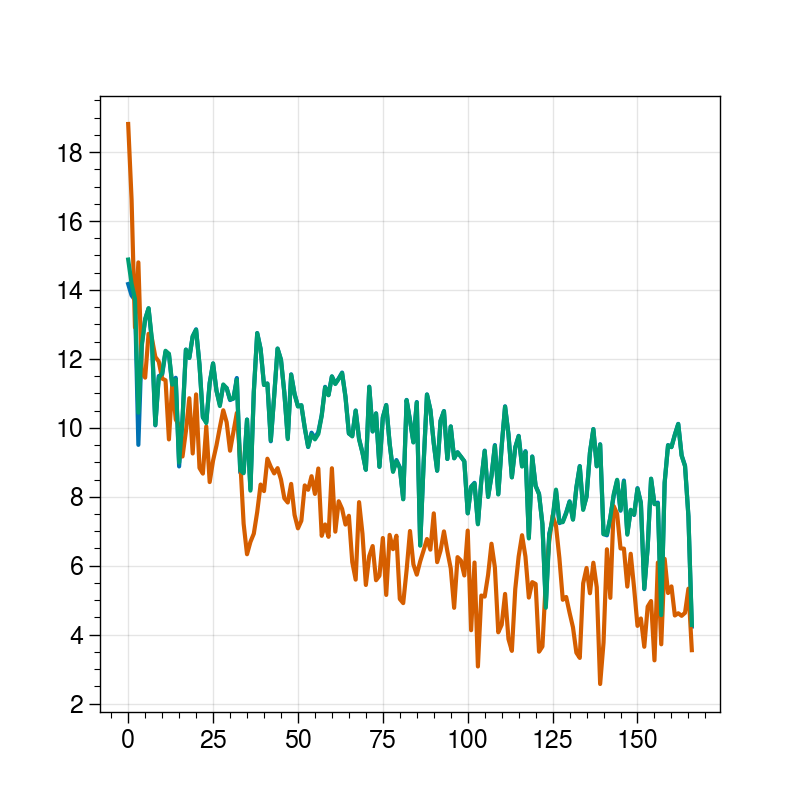

In [131]:
from scipy import signal
testQ,testRAD,testNORAD = (procWEIGHTS['Q'][36,:,:,2].data-np.mean(procWEIGHTS['Q'][36,:,:,2].data))/np.std(procWEIGHTS['Q'][36,:,:,2].data),\
(procWEIGHTS['RAD'][36,:,:,2].data-np.mean(procWEIGHTS['RAD'][36,:,:,2].data))/np.std(procWEIGHTS['RAD'][36,:,:,2].data),(procWEIGHTS['NORAD'][36,:,:,2].data-np.mean(procWEIGHTS['NORAD'][36,:,:,2].data))/np.std(procWEIGHTS['NORAD'][36,:,:,2].data)
a,a2,a3 = (np.power(pspec(np.swapaxes(testQ,0,1)).compute_radial_pspec(),2)),(np.power(pspec(np.swapaxes(testRAD,0,1)).compute_radial_pspec(),2)),\
(np.power(pspec(np.swapaxes(testNORAD,0,1)).compute_radial_pspec(),2))
plt.plot(np.log10(a[int(334/2):,int(334/2)]))
plt.plot(np.log10(a2[int(334/2):,int(334/2)]))
plt.plot(np.log10(a3[int(334/2):,int(334/2)]))
#plt.xlim(0,25)
plt.show()

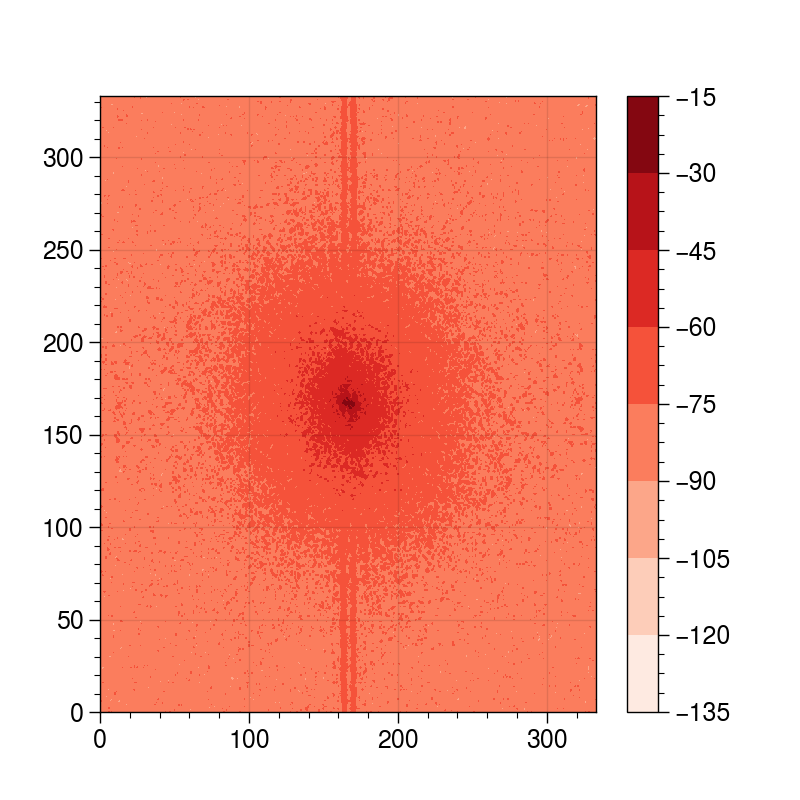

In [53]:
plt.contourf(10*np.log10(np.power(np.fft.fftshift(test(procWEIGHTS['Q'][36,:,:,1])),2)),cmap='Reds',)#levels=[-30,-20,-15,-10,-5,0,5,10])
plt.colorbar()
plt.show()

In [61]:
class pspec:
    def __init__(self,img=None):
        self.img=img
    
    def do_fft(self):
        ndim = len(self.img.shape)
        if ndim < 2 or ndim > 3:
            raise TypeError("Dimension of image must be 2D or 3D.")
        last_dim = self.img.shape[-1]
        fft_abs = np.abs(np.fft.rfftn(self.img))
        if ndim == 2:
            if last_dim % 2 == 0:
                fftstar_abs = fft_abs.copy()[:, -2:0:-1]
            else:
                fftstar_abs = fft_abs.copy()[:, -1:0:-1]
            fftstar_abs[1::, :] = fftstar_abs[:0:-1, :]
            return np.concatenate((fft_abs, fftstar_abs), axis=1)
    
    def compute_pspec(self):
        fft = np.fft.fftshift(self.do_fft())
        self._ps2D = np.power(fft, 2.)
        
    def compute_radial_pspec(self):
        self.compute_pspec()
        ps2d = self._ps2D[::-1]
        return ps2d
        
    
ft = np.fft.ifftshift(procWEIGHTS['Q'][36,:,:,1])
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

ft2 = np.fft.ifftshift(procWEIGHTS['RAD'][36,:,:,1])
ft2 = np.fft.fft2(ft2)
ft2 = np.fft.fftshift(ft2)

ft3 = np.fft.ifftshift(procWEIGHTS['NORAD'][36,:,:,1])
ft3 = np.fft.fft2(ft3)
ft3 = np.fft.fftshift(ft3)

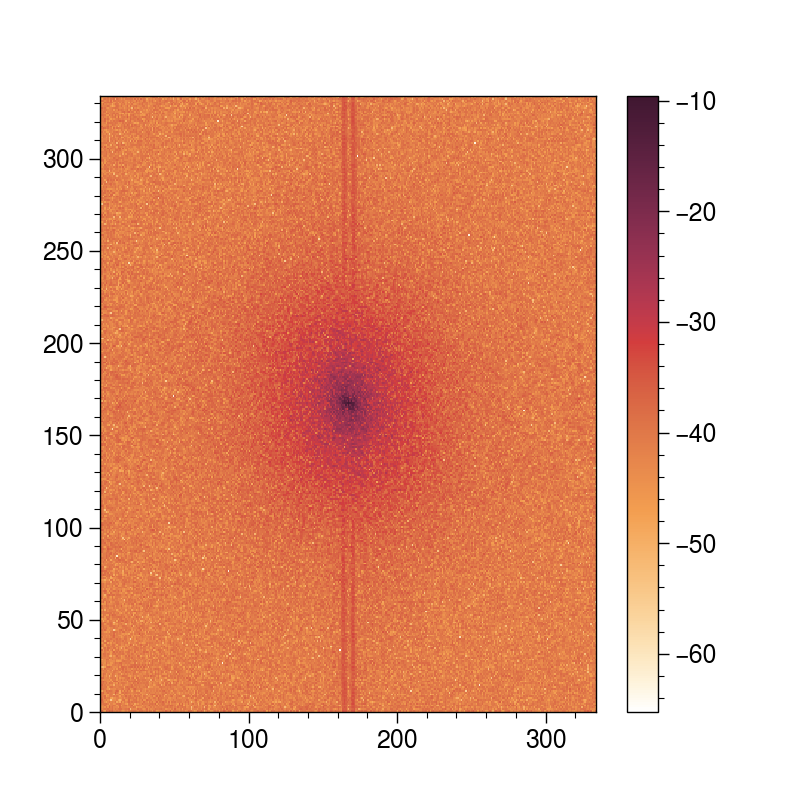

In [31]:
plt.pcolormesh(10*np.log10(np.abs(ft2)))
plt.colorbar()
plt.show()

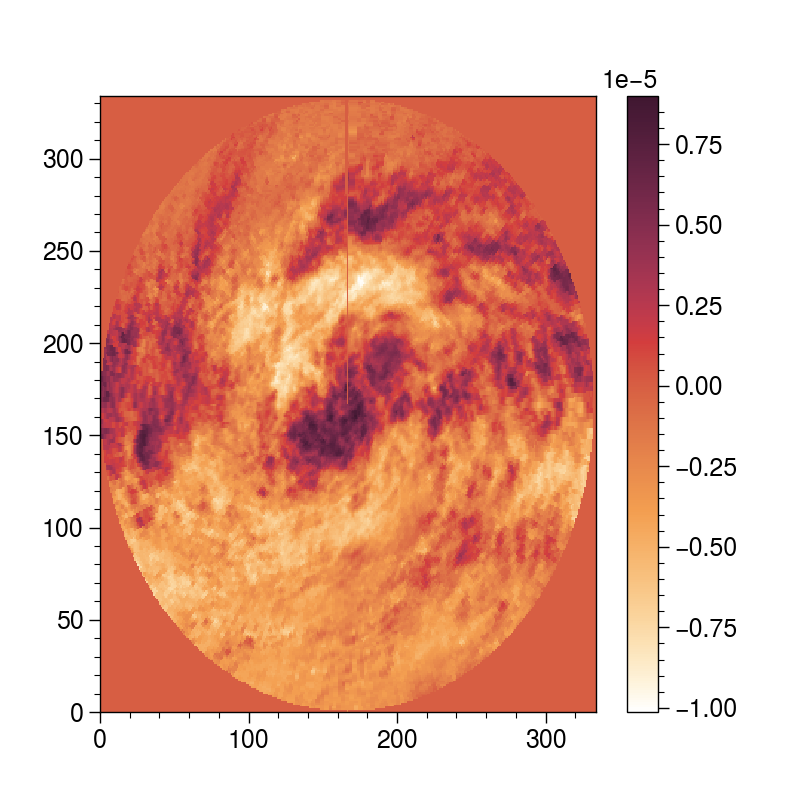

In [219]:
plt.pcolormesh(np.swapaxes(procWEIGHTS['Q'][36,:,:,1].data,0,1)-np.swapaxes(procWEIGHTS['NORAD'][36,:,:,1].data,0,1))
plt.colorbar()
plt.show()